In [2]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 33.0 MB 1.5 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.11.23 which is incompatible.


In [3]:
import cv2 
import dlib
import numpy as np
from google.colab.patches import cv2_imshow
from scipy.spatial import distance
from collections import OrderedDict
import math
from imutils import paths, resize
from tqdm import tqdm
import pandas as pd
import os
import mediapipe as mp
from sklearn.metrics import classification_report

# SUPPORT FUNCTION

In [4]:
def calculateAngle(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang

In [5]:
def rect_to_bb(rect):
	x = rect.left()
	y = rect.top()
	w = rect.right() - x
	h = rect.bottom() - y
	return (x, y, w, h)


def shape_to_np(shape, dtype="int"):
	coords = np.zeros((68, 2), dtype=dtype)
	for i in range(0, 68):
		coords[i] = (shape.part(i).x, shape.part(i).y)
	return coords

In [6]:
def extractFeature(landmarksDLIB, landmarkMP):
    # D1: 
    cheek_width = distance.euclidean(landmarksDLIB[1], landmarksDLIB[15]) 

    # D2: 
    forehead_width = distance.euclidean(landmarkMP[54], landmarkMP[284])
    
    # D3: 
    face_length = distance.euclidean(landmarksDLIB[8], landmarksDLIB[-1]) 

    # D4: 
    jaw_length = distance.euclidean(landmarksDLIB[8], landmarksDLIB[13]) 

    # D5: 
    jaw_width = distance.euclidean(landmarksDLIB[3], landmarksDLIB[13]) 

    # D6: 
    chin_width1 = distance.euclidean(landmarksDLIB[6], landmarksDLIB[10]) 

    # D7: 
    chin_width2 = distance.euclidean(landmarksDLIB[7], landmarksDLIB[9]) 

    # A1: 
    angle1 = calculateAngle(landmarksDLIB[-1], landmarksDLIB[8],landmarksDLIB[10])

    # A2: 
    angle2 = calculateAngle(landmarksDLIB[-1], landmarksDLIB[8],landmarksDLIB[13])

    # A3: 
    angle3 = calculateAngle(landmarksDLIB[2], landmarksDLIB[14],landmarksDLIB[13])

    return [
        cheek_width,
        forehead_width,
        face_length,
        jaw_length,
        jaw_width,
        chin_width1,
        chin_width2,
        angle1 ,
        angle2 ,
        angle3 ,
    ]

# Face Alignment

In [7]:
FACIAL_LANDMARKS_68_IDXS = OrderedDict([
	("mouth", (48, 68)),
	("inner_mouth", (60, 68)),
	("right_eyebrow", (17, 22)),
	("left_eyebrow", (22, 27)),
	("right_eye", (36, 42)),
	("left_eye", (42, 48)),
	("nose", (27, 36)),
	("jaw", (0, 17))
])

#For dlib’s 5-point facial landmark detector:
FACIAL_LANDMARKS_5_IDXS = OrderedDict([
	("right_eye", (2, 3)),
	("left_eye", (0, 1)),
	("nose", (4))
])

In [8]:
class FaceAligner:
	def __init__(self, predictor, desiredLeftEye=(0.35, 0.35),
		desiredFaceWidth=256, desiredFaceHeight=None):
		# store the facial landmark predictor, desired output left
		# eye position, and desired output face width + height
		self.predictor = predictor
		self.desiredLeftEye = desiredLeftEye
		self.desiredFaceWidth = desiredFaceWidth
		self.desiredFaceHeight = desiredFaceHeight

		# if the desired face height is None, set it to be the
		# desired face width (normal behavior)
		if self.desiredFaceHeight is None:
			self.desiredFaceHeight = self.desiredFaceWidth

	def align(self, image, gray, rect):
		# convert the landmark (x, y)-coordinates to a NumPy array
		shape = self.predictor(gray, rect)
		shape = shape_to_np(shape)
		if (len(shape)==68):
			# extract the left and right eye (x, y)-coordinates
			(lStart, lEnd) = FACIAL_LANDMARKS_68_IDXS["left_eye"]
			(rStart, rEnd) = FACIAL_LANDMARKS_68_IDXS["right_eye"]
		else:
			(lStart, lEnd) = FACIAL_LANDMARKS_5_IDXS["left_eye"]
			(rStart, rEnd) = FACIAL_LANDMARKS_5_IDXS["right_eye"]
			
		leftEyePts = shape[lStart:lEnd]
		rightEyePts = shape[rStart:rEnd]

		# compute the center of mass for each eye
		leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
		rightEyeCenter = rightEyePts.mean(axis=0).astype("int")

		# compute the angle between the eye centroids
		dY = rightEyeCenter[1] - leftEyeCenter[1]
		dX = rightEyeCenter[0] - leftEyeCenter[0]
		angle = np.degrees(np.arctan2(dY, dX)) - 180

		# compute the desired right eye x-coordinate based on the
		# desired x-coordinate of the left eye
		desiredRightEyeX = 1.0 - self.desiredLeftEye[0]

		# determine the scale of the new resulting image by taking
		# the ratio of the distance between eyes in the *current*
		# image to the ratio of distance between eyes in the
		# *desired* image
		dist = np.sqrt((dX ** 2) + (dY ** 2))
		desiredDist = (desiredRightEyeX - self.desiredLeftEye[0])
		desiredDist *= self.desiredFaceWidth
		scale = desiredDist / dist

		# compute center (x, y)-coordinates (i.e., the median point)
		# between the two eyes in the input image
		eyesCenter = (int((leftEyeCenter[0] + rightEyeCenter[0]) // 2), int((leftEyeCenter[1] + rightEyeCenter[1]) // 2))
		# grab the rotation matrix for rotating and scaling the face
		M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)

		# update the translation component of the matrix
		tX = self.desiredFaceWidth * 0.5
		tY = self.desiredFaceHeight * self.desiredLeftEye[1]
		M[0, 2] += (tX - eyesCenter[0])
		M[1, 2] += (tY - eyesCenter[1])

		# apply the affine transformation
		(w, h) = (self.desiredFaceWidth, self.desiredFaceHeight)
		output = cv2.warpAffine(image, M, (w, h),
			flags=cv2.INTER_CUBIC)

		# return the aligned face
		return output

# LANDMARK DETECTION

In [9]:
def landmarkDetectionDLIB(image):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('/content/drive/MyDrive/CS331/shape_predictor_68_face_landmarks.dat')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    for (i, rect) in enumerate(rects):
        shape = predictor(gray, rect)
        shape = shape_to_np(shape)
    shape = shape.tolist()
    shape.append([shape[8][0], 0])
    return shape

In [10]:
def get_unique(c):
    temp_list = list(c)
    temp_set = set()
    for t in temp_list:
        temp_set.add(t[0])
        temp_set.add(t[1])
    return list(temp_set)

In [11]:
mp_face_mesh = mp.solutions.face_mesh
connections = mp_face_mesh.FACEMESH_TESSELATION
indices = get_unique(connections)

In [12]:
def landmarkDetectionMP(image):
    d = list()
    with mp_face_mesh.FaceMesh(
        static_image_mode=False,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5) as face_mesh:

        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        for face_landmark in results.multi_face_landmarks:
            lms = face_landmark.landmark
            for index in indices:
                x  = int(lms[index].x * image.shape[1])
                y  = int(lms[index].y * image.shape[0])
                d.append([x,y])

    return d

# CODE

In [13]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/CS331/shape_predictor_68_face_landmarks.dat')
fa = FaceAligner(predictor, desiredFaceWidth=256)

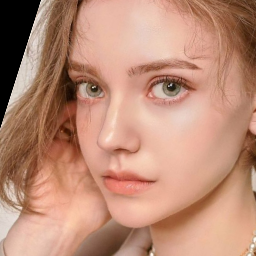

In [16]:
image = cv2.imread('/content/drive/MyDrive/CS331/Untitled1.png')
image = resize(image, width=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

rects = detector(gray, 2)
maxArea = 0
maxRect = None
for rect in rects:
    (x, y, w, h) = rect_to_bb(rect)
    currArea = w*h
    if currArea > maxArea:
        maxRect = rect
        maxArea = currArea

faceAligned = fa.align(image, gray, maxRect)
cv2_imshow(faceAligned)

## One image

In [ ]:
# image = cv2.imread('/content/drive/MyDrive/CS331/data/train/round/round (100).jpg')
# image = resize(image, width=500)
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# rects = detector(gray, 2)
# maxArea = 0
# maxRect = None
# for rect in rects:
#     (x, y, w, h) = rect_to_bb(rect)
#     currArea = w*h
#     if currArea > maxArea:
#         maxRect = rect
#         maxArea = currArea

# faceAligned = fa.align(image, gray, maxRect)
# landmarksDLIB = landmarkDetectionDLIB(faceAligned)
# landmarksMP = landmarkDetectionMP(faceAligned)

# features = extractFeature(landmarksDLIB, landmarksMP)

In [ ]:
# cv2.line(faceAligned, landmarksDLIB[1], landmarksDLIB[15], (255,0,0), 1)
# cv2.line(faceAligned, landmarksMP[54], landmarksMP[284], (255,0,0), 1)

# cv2.line(faceAligned, landmarksDLIB[8], landmarksDLIB[-1], (255,0,0), 1)
# cv2.line(faceAligned, landmarksDLIB[8], landmarksDLIB[13], (255,0,0), 1)
# cv2.line(faceAligned, landmarksDLIB[3], landmarksDLIB[13], (255,0,0), 1)
# cv2.line(faceAligned, landmarksDLIB[6], landmarksDLIB[10], (255,0,0), 1)
# cv2.line(faceAligned, landmarksDLIB[7], landmarksDLIB[9], (255,0,0), 1)
# cv2_imshow(faceAligned)


## Calculate features

In [ ]:
features = []
labels = []

In [ ]:
import tensorflow as tf

In [ ]:
image_paths = list(paths.list_images('/content/drive/MyDrive/CS331/data/test'))
with tf.device('/gpu:0'):
    for path in tqdm(sorted(image_paths)):
        label = path.split(os.path.sep)[-2]
        image = cv2.imread(path)
        image = resize(image, width=500)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        rects = detector(gray, 2)
        maxArea = 0
        maxRect = None
        for rect in rects:
            (x, y, w, h) = rect_to_bb(rect)
            currArea = w*h
            if currArea > maxArea:
                maxRect = rect
                maxArea = currArea

        try:
            faceAligned = fa.align(image, gray, maxRect)
            landmarksDLIB = landmarkDetectionDLIB(faceAligned)
            landmarksMP = landmarkDetectionMP(faceAligned)

            feature = extractFeature(landmarksDLIB, landmarksMP)
            features.append(feature)
            labels.append(label)
        except:
            print(1)

100%|██████████| 1000/1000 [43:02<00:00,  2.58s/it]


In [ ]:
df = pd.DataFrame(list(zip(features, labels)),
               columns =['Features', 'Labels'])
df.to_csv('/content/drive/MyDrive/CS331/method/landmark/faceFeature_test.csv', index=False)

## Shape recognition

In [ ]:
def loadFeatures(path):
    features = list()
    labels = list()
    df = pd.read_csv(path)
    arr = df['Features'].to_numpy()
    labels = df['Labels'].values.tolist()
    for i in arr:
        t = i[1:-1].split(', ')
        feature = [float(x) for x in t]
        features.append(feature)
    return features, labels

In [ ]:
def shapeRecognition(features):
    cheek_width = features[0]
    forehead_width = features[1]
    face_length = features[2]
    jaw_length = features[3]
    jaw_width = features[4]

    face_length_width_ratio = face_length / cheek_width

    jawwidth_forehead_width_ratio = jaw_width / forehead_width if jaw_width > forehead_width else forehead_width / jaw_width

    cheek_forehead_width_ratio =  cheek_width / forehead_width 
    
    jawlength_forehead_width_ratio = jaw_length / forehead_width 



    shape = 'Inconclusive'


    if face_length_width_ratio <= 1.2:
        if jawwidth_forehead_width_ratio <= 1.2 and cheek_forehead_width_ratio <= 1.2:
            shape = 'Square'
        elif jawwidth_forehead_width_ratio <= 1.2 and face_length_width_ratio >  jawwidth_forehead_width_ratio:
            shape = 'Round'

    else:
        if cheek_forehead_width_ratio <= 1.2 and jawwidth_forehead_width_ratio <= 1.0:
            shape = 'Heart'
        elif face_length_width_ratio >= 1.4 and jawwidth_forehead_width_ratio <= 1.2 and cheek_forehead_width_ratio <= 1.2:
            shape = 'Oblong'
        elif jawlength_forehead_width_ratio <= 1.0 and cheek_forehead_width_ratio <= 1.2:
            shape = 'Oval'

    return shape

In [ ]:
featuresTrain, labelsTrain = loadFeatures('/content/drive/MyDrive/CS331/method/landmark/faceFeature.csv')
featuresTest, labelsTest = loadFeatures('/content/drive/MyDrive/CS331/method/landmark/faceFeature_test.csv')

In [ ]:
shapes = list()
for i in features[800:1600]:
    shape = shapeRecognition(i)
    shapes.append(shape)

countPredictedShapes = {i:0 for i in ['Square', 'Heart', 'Oval', 'Round', 'Oblong', 'Inconclusive']}
for i in shapes:
    countPredictedShapes[i] += 1
countPredictedShapes

{'Square': 0,
 'Heart': 3,
 'Oval': 257,
 'Round': 0,
 'Oblong': 423,
 'Inconclusive': 117}

# Model

In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
lb = LabelEncoder()


In [ ]:
def modifiedFeatures(features):
    modified = list()
    for i in features:
        temp = list()
        temp.append(i[2] / i[1]) # forehead_width / cheek_width
        temp.append(i[0] / i[2]) # cheek_width / face_length
        temp.append(i[1] / i[2]) # forehead_width / face_length
        temp.append(i[0] / i[4]) # forehead_width / jaw_width
        temp.append(i[5] / i[4]) # chin_width1 / jaw_width
        temp.append(i[3] / i[5]) # jaw_length / chin_width1
        temp.append(i[5] / i[0]) # chin_width1 / cheek_width
        temp.append(i[4] / i[1]) # jaw_width / forehead_width
        temp.append(i[3] / i[4]) # jaw_length / jaw_width
        temp.append(i[6] / i[5]) # chin_width2 / chin_width1


        temp.append(feature[-1]/180)
        temp.append(feature[-2]/180)
        temp.append(feature[-3]/180)
        modified.append(temp)
    return modified

In [ ]:
xTrain = modifiedFeatures(featuresTrain)
xTest = modifiedFeatures(featuresTest)
yTrain = lb.fit_transform(labelsTrain)
yTest = lb.fit_transform(labelsTest)

In [ ]:
model = SVC()
model.fit(xTrain, yTrain)

SVC()

In [ ]:
yTestPre = model.predict(xTest)
print("Test Accuracy:", accuracy_score(yTest, yTestPre))

Test Accuracy: 0.499


In [ ]:
print(classification_report(yTest, yTestPre,target_names=['heart', 'oblong', 'oval', 'round', 'square']))

              precision    recall  f1-score   support

       heart       0.45      0.49      0.47       200
      oblong       0.66      0.71      0.69       200
        oval       0.37      0.30      0.33       200
       round       0.42      0.41      0.41       200
      square       0.54      0.59      0.57       200

    accuracy                           0.50      1000
   macro avg       0.49      0.50      0.49      1000
weighted avg       0.49      0.50      0.49      1000



Text(13.499999999999996, 0.5, 'Ground Truth')

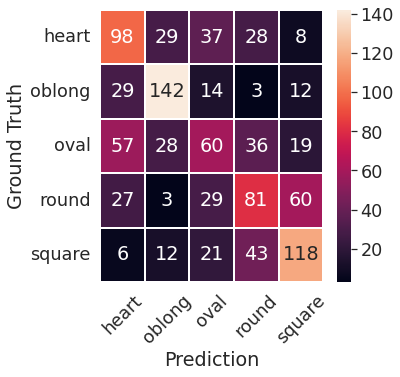

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
sns.set(font_scale=1.6)
cm = confusion_matrix(yTest, yTestPre, labels=model.classes_)
sns.heatmap(cm, linewidths=1, annot=True, ax=ax, fmt='g', 
            xticklabels=['heart', 'oblong', 'oval', 'round', 'square'],
            yticklabels=['heart', 'oblong', 'oval', 'round', 'square'],
            )
plt.xticks(rotation=45)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')


In [ ]:
model = KNeighborsClassifier()
model.fit(xTrain, yTrain)

KNeighborsClassifier()

In [ ]:
print(classification_report(yTest, yTestPre,target_names=['heart', 'oblong', 'oval', 'round', 'square']))

              precision    recall  f1-score   support

       heart       0.46      0.56      0.51       200
      oblong       0.64      0.71      0.67       200
        oval       0.38      0.37      0.38       200
       round       0.46      0.42      0.44       200
      square       0.62      0.47      0.53       200

    accuracy                           0.51      1000
   macro avg       0.51      0.51      0.51      1000
weighted avg       0.51      0.51      0.51      1000



Text(13.499999999999996, 0.5, 'Ground Truth')

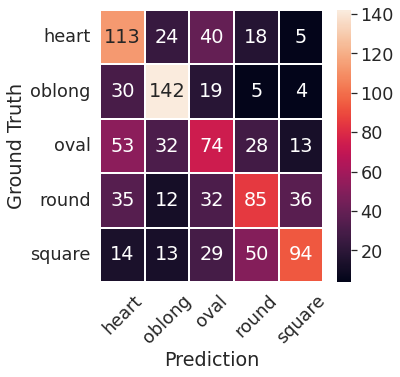

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
sns.set(font_scale=1.6)
cm = confusion_matrix(yTest, yTestPre, labels=model.classes_)
sns.heatmap(cm, linewidths=1, annot=True, ax=ax, fmt='g', 
            xticklabels=['heart', 'oblong', 'oval', 'round', 'square'],
            yticklabels=['heart', 'oblong', 'oval', 'round', 'square'],
            )
plt.xticks(rotation=45)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')


In [ ]:
yTestPre = model.predict(xTest)
print("Test Accuracy:", accuracy_score(yTest, yTestPre))

Test Accuracy: 0.508
